In [46]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.anova import anova_lm

In [496]:
extraction_dir = './survey-dataset/'

# List the files in the directory
extracted_files = os.listdir(extraction_dir)
extracted_files

['corr_data.csv',
 '.DS_Store',
 'transformed_data.csv',
 'nan_no_choice_counts.csv',
 'surveyId-mapping.csv',
 'data.csv',
 'regression_data.csv',
 'transformed_task_wise.csv',
 'All_data_Survey_questions_with_descriptions.csv',
 'mapped_data.csv',
 'old-execution',
 'Valid_users_Survey_questions_with_descriptions.csv',
 'summary_with_descriptions_corrected.csv']

In [497]:
# Load the user-wise data
data_path = os.path.join(extraction_dir, 'data.csv')
data = pd.read_csv(data_path)
print(data.columns)

Index(['id', 'control task name', 'control task correctness',
       'control task validity', 'control task time in seconds',
       'control task answer', 'control task actions', 'ct-task-easiness',
       'ct-task-length', 'ct-task-interruption', 'ct-bug-found',
       'ct-bug-description', 'ct-debugger-help', 'ct-debugger-enjoy',
       'ct-debugger-efficient', 'ct-debugger-intuitive',
       'ct-debugger-easiness', 'ct-debugger-learn', 'treatment task name',
       'treatment task correctness', 'treatment task validity',
       'treatment task time in seconds', 'treatment task answer',
       'treatment task actions', 'tt-task-easiness', 'tt-task-length',
       'tt-task-interruption', 'tt-bug-found', 'tt-bug-description',
       'tt-debugger-help', 'tt-debugger-enjoy', 'tt-debugger-efficient',
       'tt-debugger-intuitive', 'tt-debugger-easiness', 'tt-debugger-learn',
       'experiment-easiness', 'experiment-length', 'ocd-help',
       'ocd-performance', 'ocd-productivity', 'ocd

In [498]:
print(data.head())

                                                  id control task name  \
0  User-70721c71-20d5-0d00-a35f-0b230f90ea5645210...        Lights Out   
1  User-88a6276f-6bd5-0d00-a386-0d050eac3a2a50500...        Lights Out   
2  User-a2904209-ccc2-0d00-9778-6c840e6ed7ae51481...        Lights Out   
3  User-20d31f99-86c4-0d00-a363-69a60df93b8251470...          Ammolite   
4  User-4a048f49-eec8-0d00-89f7-047b0e96ebda52859...          Ammolite   

  control task correctness  control task validity  \
0                     true                   True   
1                      nil                  False   
2                     true                   True   
3                     true                   True   
4                     true                   True   

   control task time in seconds  \
0                          2610   
1                           362   
2                           904   
3                          1060   
4                          2186   

                         

In [226]:
survey_data_path = os.path.join(extraction_dir, 'surveyId-mapping.csv')
survey_mapping = pd.read_csv(survey_data_path)
print(survey_mapping.columns)

Index(['Question id', 'Question', 'Short_Question'], dtype='object')


Generate a CSV file containing count of all valid, empty and na records.

In [237]:
# Function to check if a value is an empty string, string with only spaces, NaN, or contains only backspaces
def check_empty_or_na(value):
    if pd.isna(value):
        return 'Empty or Spaces or NaN'
    elif isinstance(value, str):
        # Strip whitespace and check if empty or just spaces
        stripped = value.strip()
        if stripped == '' or stripped.lower() in ['nan', 'na', 'n/a', 'none', 'null', '-', ' ', ' ']:
            return 'Empty or Spaces or NaN'
    #elif isinstance(value, (int, float)):
    #    return 'Empty or Spaces or NaN'
    return 'Valid'

# Apply the function to the 'ct-debugger-intuitive' column
empty_or_na_counts = data['ct-debugger-intuitive'].apply(check_empty_or_na).value_counts()
print("\nCounts of empty or NA values in 'ct-debugger-intuitive':\n", empty_or_na_counts)

# Function to extract short question name by stripping prefixes
def extract_short_question(col):
    prefixes = ['control ', 'ct-', 'treatment ', 'tt-']
    for prefix in prefixes:
        if col.startswith(prefix):
            return col.replace(prefix, '')
    return col

# Dictionary to store the summary for each column
column_summaries = []

# Apply the function to each column and summarize the counts
for col in data.columns:
    col_summary = data[col].apply(check_empty_or_na).value_counts().to_dict()
    col_summary['Column_name'] = col
    col_summary['description'] = extract_short_question(col)
    column_summaries.append(col_summary)

# Create a DataFrame to display the results
summary_df = pd.DataFrame(column_summaries).fillna(0).astype({'Empty or Spaces or NaN': int, 'Valid': int})

# Merge with survey mapping to get the descriptions
summary_df = summary_df.reset_index(drop=True)
summary_df = summary_df.merge(survey_mapping[['Short_Question', 'Question']], left_on='description', right_on='Short_Question', how='left')

# Replace the 'description' column with the actual questions
summary_df['description'] = summary_df['Question']
summary_df = summary_df.drop(columns=['Short_Question', 'Question'])

# Rename the 'Column' column to 'Column name' and reorder columns
summary_df = summary_df[['Column_name', 'description', 'Valid', 'Empty or Spaces or NaN']]

# Save the summary to a new CSV file
output_csv_path = os.path.join(extraction_dir,'summary_with_descriptions_corrected.csv')
summary_df.to_csv(output_csv_path, index=False)

print(summary_df.head(20))

                     Column_name  \
0                             id   
1              control task name   
2       control task correctness   
3          control task validity   
4   control task time in seconds   
5            control task answer   
6           control task actions   
7               ct-task-easiness   
8                 ct-task-length   
9           ct-task-interruption   
10                  ct-bug-found   
11            ct-bug-description   
12              ct-debugger-help   
13             ct-debugger-enjoy   
14         ct-debugger-efficient   
15         ct-debugger-intuitive   
16          ct-debugger-easiness   
17             ct-debugger-learn   
18           treatment task name   
19    treatment task correctness   

                                          description  Valid  \
0                                                 NaN     74   
1                                                 NaN     74   
2                                                 N

Remove empty values (or users) from the dataset

In [329]:
# Function to check if a value is an empty string, string with only spaces, NaN, or contains only backspaces
def replace_empty_or_na(value):
    if pd.isna(value):
        return np.nan
    elif isinstance(value, str):
        # Strip whitespace and check if empty or just spaces
        stripped = value.strip()
        if stripped == '' or stripped.lower() in ['nan', 'na', 'n/a', 'none', 'null', '-', ' ', ' ']:
            return np.nan
    #elif isinstance(value, (int, float)):
    #    return 'Empty or Spaces or NaN'
    return value

Remove Invalid users from the dataset

In [214]:
def remove_invalid_values(data):
    # Function to check if a value is an empty string, string with only spaces, NaN, or False
    def is_invalid(value):
        if pd.isna(value):
            return True
        elif isinstance(value, str) and value.strip() == '':
            return True
        elif value == False:
            return True
        elif value == "False" or value == "false":
            return True
        else:
            return False


    # Identify rows that will be filtered out due to validity conditions
    filtered_out_rows = data[data['control task validity'].apply(is_invalid) |
                            data['treatment task validity'].apply(is_invalid)]

    # Remove the filtered rows from data
    data = data[~data['id'].isin(filtered_out_rows['id'])]
    #print(len(data))
    return data


def verify_users_removed(data, filtered_out_rows):
    # List of user IDs to check
    user_ids_to_check = [
        "User-70721c71-20d5-0d00-a35f-0b230f90ea5645210598000000",
        "User-88a6276f-6bd5-0d00-a386-0d050eac3a2a50500325000000",
        "User-4a048f49-eec8-0d00-89f7-047b0e96ebda52859119709000",
        "User-a5ec8da3-59c3-0d00-97f2-7c7d0387d14954860731588000",
        "User-d8e0d7a9-bfcf-0d00-a211-ad1e08c6c53a32392439000000",
        "User-d6e8c056-68d5-0d00-9799-60a00d27027937206036743000",
        "User-edb402d9-60c5-0d00-a353-ef9803b5560334845604104000",
        "User-283eed8d-68d5-0d00-a31e-ceba0499997938131689000000",
        "User-ec6a83f8-cbc2-0d00-9781-d55b00cbdc0451200750337000",
        "User-40188883-68d5-0d00-a323-84de0eac3a2a37957288000000",
        "User-ee372e08-c3c4-0d00-9797-21750849ac5251832152083000",
        "User-50f67874-57d5-0d00-a370-853104c02a3454690194000000",
        "User-fa80d14e-68d5-0d00-a367-1c5903d733c337072906518000",
        "User-d135f8ad-c8c8-0d00-9770-af7c0785edc264134978024000",
        "User-b0617330-82c9-0d00-915f-d5280cb6f48861693038000000"
    ]

    # Filter the data to include only the specified user IDs
    rows_to_check = data[data['id'].isin(user_ids_to_check)]
    print(len(rows_to_check))

    # Get the values of the validity columns for the specified user IDs
    validity_columns = ['control task validity', 'treatment task validity']
    validity_values = rows_to_check[['id'] + validity_columns]
    print(validity_values)

    return rows_to_check

All users: 74
Number of valid pairs after removing invalid users: 59
Number of valid pairs after replacing empty values with NAs: 59


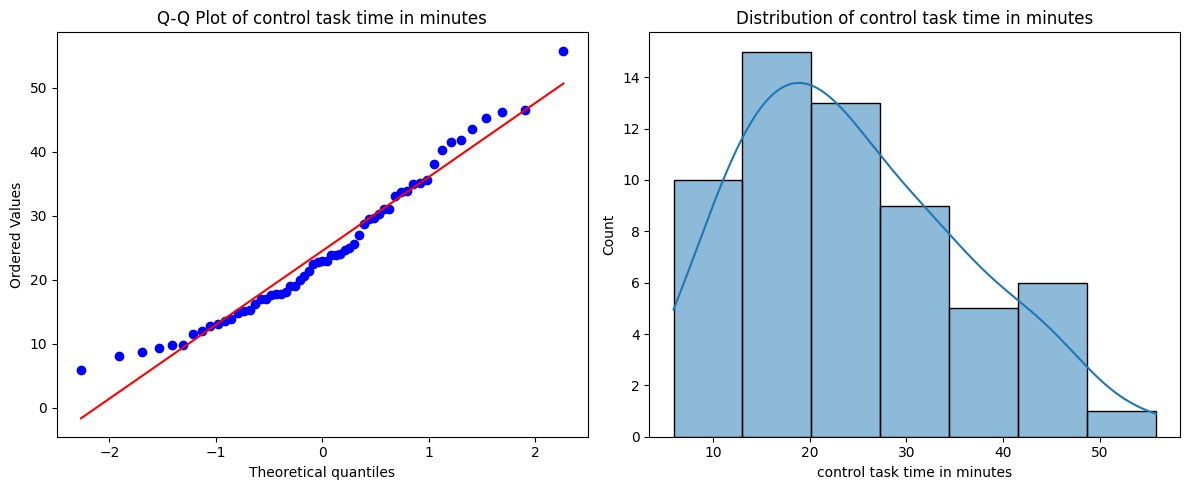

Shapiro-Wilk test p-value for control task time in minutes: 0.05174933586141025


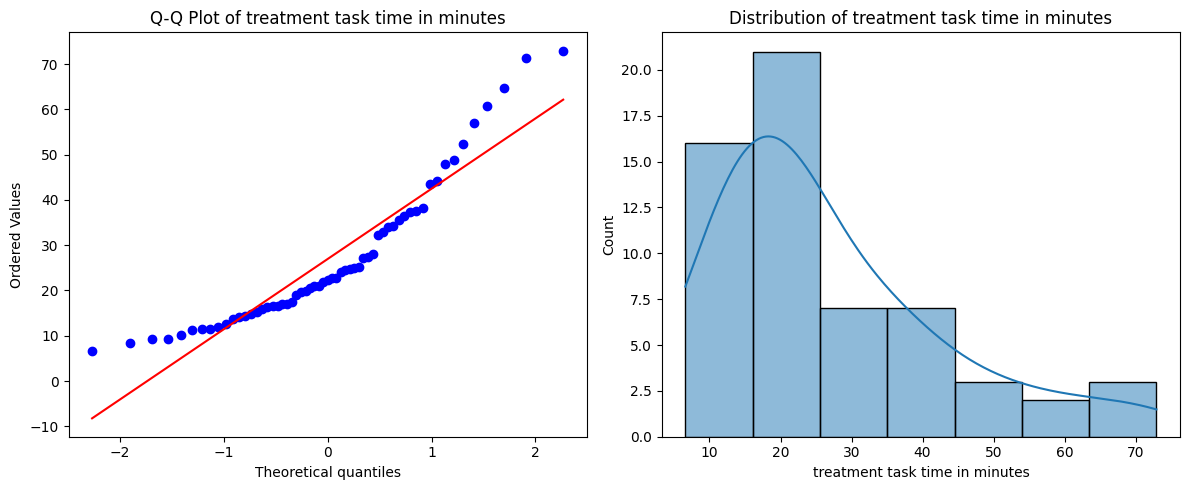

Shapiro-Wilk test p-value for treatment task time in minutes: 3.463242021682725e-05


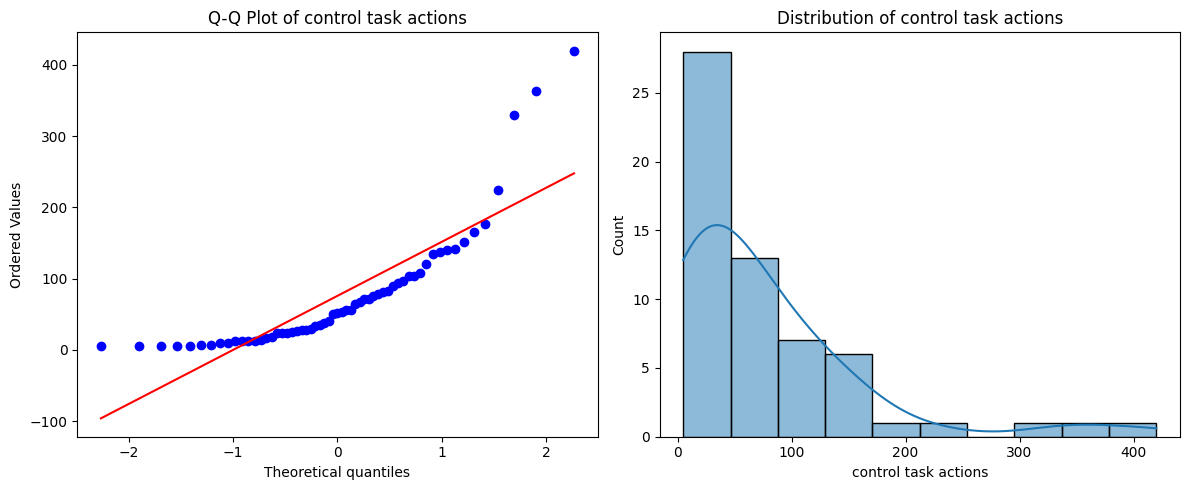

Shapiro-Wilk test p-value for control task actions: 8.619840674619203e-09


In [516]:
# Load the data
data = pd.read_csv(data_path)

print(f"All users: {len(data)}")
data = remove_invalid_values(data)
print(f"Number of valid pairs after removing invalid users: {len(data)}")

#replace empty values with NaN
for col in data.columns:
    data[col] = data[col].apply(replace_empty_or_na)
    
print(f"Number of valid pairs after replacing empty values with NAs: {len(data)}")

# Convert 'time in seconds' to 'time in minutes' with error handling
data['control task time in seconds'] = pd.to_numeric(data['control task time in seconds'], errors='coerce') / 60
data['treatment task time in seconds'] = pd.to_numeric(data['treatment task time in seconds'], errors='coerce') / 60
data.rename(columns={'control task time in seconds': 'control task time in minutes', 
                     'treatment task time in seconds': 'treatment task time in minutes'}, inplace=True)

# Function to create Q-Q plot and histogram for continuous variables
def plot_distribution(data, column):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Q-Q plot
    stats.probplot(data[column], dist="norm", plot=ax1)
    ax1.set_title(f"Q-Q Plot of {column}")
    
    # Histogram
    sns.histplot(data[column], kde=True, ax=ax2)
    ax2.set_title(f"Distribution of {column}")
    
    plt.tight_layout()
    plt.show()
    
    # Shapiro-Wilk test
    _, p_value = stats.shapiro(data[column])
    print(f"Shapiro-Wilk test p-value for {column}: {p_value}")

# Check distributions for continuous metrics
plot_distribution(data, 'control task time in minutes')
plot_distribution(data, 'treatment task time in minutes')

plot_distribution(data, 'control task actions')
# plot_distribution(data, 'treatment task actions')

Preprocess dataset, remove invalid users, na values, empty values

In [517]:
import pandas as pd
import numpy as np
from scipy import stats

# Load the data
data = pd.read_csv(data_path)

print(f"All users: {len(data)}")
data = remove_invalid_values(data)
print(f"Number of valid pairs after removing invalid users: {len(data)}")

#replace empty values with NaN
for col in data.columns:
    data[col] = data[col].apply(replace_empty_or_na)


# Verify the data types
print(data.dtypes)
print(f"Number of valid pairs after replacing empty values with NAs: {len(data)}")

# Convert 'time in seconds' to 'time in minutes' with error handling
data['control task time in seconds'] = pd.to_numeric(data['control task time in seconds'], errors='coerce') / 60
data['treatment task time in seconds'] = pd.to_numeric(data['treatment task time in seconds'], errors='coerce') / 60
data.rename(columns={'control task time in seconds': 'control task time in minutes', 
                     'treatment task time in seconds': 'treatment task time in minutes'}, inplace=True)

# Remove users starting with "Pilot"
#data = data[~data['id'].str.startswith('Pilot', na=False)]
#print(f"Number of valid pairs after removing pilot data: {len(data)}")

def remove_outliers(df, columns):
    for col in columns:
        q99 = df[col].quantile(0.99)
        df = df[df[col] <= q99]
    print(f"Total number of entries (after removing outliers ): {len(df)}")
    return df

All users: 74
Number of valid pairs after removing invalid users: 59
id                                object
control task name                 object
control task correctness          object
control task validity               bool
control task time in seconds       int64
control task answer               object
control task actions               int64
ct-task-easiness                  object
ct-task-length                    object
ct-task-interruption              object
ct-bug-found                      object
ct-bug-description                object
ct-debugger-help                  object
ct-debugger-enjoy                 object
ct-debugger-efficient             object
ct-debugger-intuitive             object
ct-debugger-easiness              object
ct-debugger-learn                 object
treatment task name               object
treatment task correctness        object
treatment task validity           object
treatment task time in seconds    object
treatment task answer        

Perform Wilcoxon signed-rank test for Time and Actions

In [518]:
def get_valid_pairs(data, control_col, treatment_col):
    paired_data = data[[control_col, treatment_col]].copy()
    paired_data.dropna(inplace=True)
    # print(f"Number of valid pairs after removing na is {control_col} and {treatment_col}: {len(paired_data)}")
    paired_data = paired_data[paired_data[control_col].apply(lambda x: str(x).replace('.', '').isdigit())]
    paired_data = paired_data[paired_data[treatment_col].apply(lambda x: str(x).replace('.', '').isdigit())]
    paired_data = paired_data.astype(float)
    # print(f"Number of valid pairs after digits is {control_col} and {treatment_col}: {len(paired_data)}")

    # Remove outliers
    #paired_data = remove_outliers(paired_data, [control_col, treatment_col])
    
    return paired_data

def perform_wilcoxon_test(paired_data, variable_name):
    control_col = paired_data.columns[0]
    treatment_col = paired_data.columns[1]
    
    statistic, p_value = stats.wilcoxon(paired_data[control_col], paired_data[treatment_col])
    
    print(f"\nWilcoxon signed-rank test for {variable_name}:")
    print(f"Number of valid pairs: {len(paired_data)}")
    print(f"Statistic: {statistic}")
    print(f"p-value: {p_value:.4f}")
    
    # Calculate correct effect size
    z = (statistic - ((len(paired_data) * (len(paired_data) + 1)) / 4)) / np.sqrt((len(paired_data) * (len(paired_data) + 1) * (2 * len(paired_data) + 1)) / 24)
    r = abs(z) / np.sqrt(len(paired_data) * 2)
    print(f"Z-score: {z:.4f}")
    print(f"Effect size (r): {r:.4f}")
    
    # Print descriptive statistics
    print("\nDescriptive statistics:")
    print(paired_data.agg(['mean', 'median', 'std']).T)
    
    # Calculate and print the number of improvements, deteriorations, and ties
    diff = paired_data[treatment_col] - paired_data[control_col]
    improvements = (diff < 0).sum()
    deteriorations = (diff > 0).sum()
    ties = (diff == 0).sum()
    
    print(f"\nImprovements (treatment < control): {improvements}")
    print(f"Deteriorations (treatment > control): {deteriorations}")
    print(f"Ties (treatment = control): {ties}")
    
    # Additional information
    print(f"\nMean difference (treatment - control): {diff.mean():.4f}")
    print(f"Median difference (treatment - control): {diff.median():.4f}")

# Get valid pairs
time_pairs = get_valid_pairs(data, 'control task time in minutes', 'treatment task time in minutes')
action_pairs = get_valid_pairs(data, 'control task actions', 'treatment task actions')

# Perform Wilcoxon test for time in seconds
perform_wilcoxon_test(time_pairs, 'time in minutes')

# Perform Wilcoxon test for actions
perform_wilcoxon_test(action_pairs, 'actions')

# Print information about excluded data
print("\nData cleaning summary:")
print(f"Total number of entries (after removing Pilot users): {len(data)}")
print(f"Valid pairs for time analysis: {len(time_pairs)}")
print(f"Valid pairs for action analysis: {len(action_pairs)}")


Wilcoxon signed-rank test for time in minutes:
Number of valid pairs: 59
Statistic: 835.0
p-value: 0.7059
Z-score: -0.3774
Effect size (r): 0.0347

Descriptive statistics:
                                     mean     median        std
control task time in minutes    24.500565  22.933333  11.484309
treatment task time in minutes  26.946045  22.333333  16.117264

Improvements (treatment < control): 32
Deteriorations (treatment > control): 27
Ties (treatment = control): 0

Mean difference (treatment - control): 2.4455
Median difference (treatment - control): -2.0333

Wilcoxon signed-rank test for actions:
Number of valid pairs: 59
Statistic: 737.0
p-value: 0.3589
Z-score: -1.1171
Effect size (r): 0.1028

Descriptive statistics:
                             mean  median         std
control task actions    75.779661    52.0   86.276634
treatment task actions  72.610169    35.0  111.921619

Improvements (treatment < control): 34
Deteriorations (treatment > control): 24
Ties (treatment = co

Perform Mann-Whitney U test for Task-wise analysis

In [519]:
import pandas as pd
import numpy as np
from scipy import stats

print(f"All users: {len(data)}")

def remove_outliers(df, column):
    q99 = df[column].quantile(0.99)
    return df[df[column] <= q99]

def prepare_data(data, task, variable):
    task_data = data[data['control task name'] == task].copy()
    task_data['condition'] = 'control'
    task_data[variable] = task_data[f'control task {variable}']
    
    treatment_data = data[data['treatment task name'] == task].copy()
    treatment_data['condition'] = 'treatment'
    treatment_data[variable] = treatment_data[f'treatment task {variable}']
    
    combined_data = pd.concat([task_data, treatment_data])
    combined_data = combined_data[['condition', variable]].dropna()
    combined_data[variable] = pd.to_numeric(combined_data[variable], errors='coerce')
    print(f"Number of valid pairs before dropping NAs for {variable} in {task} task: {len(combined_data)}")
    combined_data = combined_data.dropna()
    print(f"Number of valid pairs for {variable} in {task} task: {len(combined_data)}")
    
    # Remove outliers
    # combined_data = remove_outliers(combined_data, variable)
    
    return combined_data

def perform_mann_whitney_test(data, variable, task):
    control_data = data[data['condition'] == 'control'][variable]
    treatment_data = data[data['condition'] == 'treatment'][variable]
    
    statistic, p_value = stats.mannwhitneyu(control_data, treatment_data, alternative='two-sided')
    
    # Calculate rank-biserial correlation (effect size)
    n1, n2 = len(control_data), len(treatment_data)
    effect_size = 2 * statistic / (n1 * n2) - 1
    
    print(f"\nMann-Whitney U test for {variable} in {task} task:")
    print(f"Number of control samples: {n1}")
    print(f"Number of treatment samples: {n2}")
    print(f"U statistic: {statistic}")
    print(f"p-value: {p_value:.4f}")
    print(f"Effect size (rank-biserial correlation): {effect_size:.4f}")
    
    # Print descriptive statistics
    print("\nDescriptive statistics:")
    print(data.groupby('condition')[variable].agg(['count', 'mean', 'median', 'std']))
    
    # Additional information
    print(f"\nMean difference (treatment - control): {treatment_data.mean() - control_data.mean():.4f}")
    print(f"Median difference (treatment - control): {treatment_data.median() - control_data.median():.4f}")

tasks = ['Ammolite', 'Lights Out']
variables = ['time in minutes', 'actions']

for task in tasks:
    for variable in variables:
        task_data = prepare_data(data, task, variable)
        perform_mann_whitney_test(task_data, variable, task)

print("\nData cleaning summary:")
print(f"Total number of entries (after removing Pilot users): {len(data)}")

All users: 59
Number of valid pairs before dropping NAs for time in minutes in Ammolite task: 59
Number of valid pairs for time in minutes in Ammolite task: 59

Mann-Whitney U test for time in minutes in Ammolite task:
Number of control samples: 28
Number of treatment samples: 31
U statistic: 530.0
p-value: 0.1472
Effect size (rank-biserial correlation): 0.2212

Descriptive statistics:
           count       mean     median        std
condition                                        
control       28  23.870238  22.641667  11.841905
treatment     31  18.955376  16.633333   7.780645

Mean difference (treatment - control): -4.9149
Median difference (treatment - control): -6.0083
Number of valid pairs before dropping NAs for actions in Ammolite task: 59
Number of valid pairs for actions in Ammolite task: 59

Mann-Whitney U test for actions in Ammolite task:
Number of control samples: 28
Number of treatment samples: 31
U statistic: 529.5
p-value: 0.1492
Effect size (rank-biserial correlati

Map categorical columns to numerical scale for statistical analysis, i.e., regression model 

In [520]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load the data
#data = pd.read_csv('data.csv')

# Remove users starting with "Pilot"
#data = data[~data['id'].str.startswith('Pilot', na=False)]

# Remove unnecessary columns that contains subjective data
columns_to_remove = ['id', 'control task validity','treatment task validity','control task answer', 'treatment task answer', 'ct-bug-description', 'tt-bug-description']
data.drop(columns=columns_to_remove, inplace=True)

# Define the mappings
qualitative_mapping = {
    np.nan: np.nan, "No choice": np.nan, "Strongly Disagree": 1, "Disagree": 2,
    "Nor disagree or agree": 3, "Agree": 4, "Strongly Agree": 5
}

education_mapping = {
    np.nan: np.nan, "No choice": np.nan, "High School but did not graduate": 0,
    "High School": 1, "High School graduate or GED": 1, "Some college or 2-year degree": 2,
    "Bachelor in STEM (Science, Technology, Engineering and Mathematics)": 3,
    "Bachelor in a different area than CS or STEM": 3, "Bachelor in CS (Computer Science)": 3,
    "Master in CS": 4, "Master in STEM": 4, "Master in a different area than CS or STEM": 4,
    "PhD or higher academic title in STEM": 5, "PhD or higher academic title in CS": 5,
    "PhD or higher academic title in a different area than CS or STEM": 5
}

experience_mapping = {
    np.nan: np.nan, "No choice": np.nan, "< 1": 1, "1-2 years": 2, "3-5 years": 3,
    "6-10 years": 4, "More than 10": 5, "More than 10 years": 5
}

frequency_mapping = {
    np.nan: np.nan, "No choice": np.nan, "At least once per year": 1,
    "Less than once per month": 1, "At least once per month": 2,
    "At least once per week": 3, "At least once per day": 4,
}

interruption_mapping = {
    np.nan: np.nan, "No choice": np.nan, "Not interrupted": 1, "1-2 minutes": 2,
    "up to 5 minutes": 3, 'up to 10 minutes': 4, 'more than 10 minutes': 5
}

job_position_mapping = {
    np.nan: np.nan, "No choice": np.nan, "Student": 1, "Part-Time Dev": 2,
    "Full-Time Dev": 3, "Unemployed": 4, "Self-Employed": 5
}

bug_found_mapping = {np.nan: np.nan, "No choice": np.nan, "No": 0, "Yes": 1}

correctness_and_validity_mapping = {
    np.nan: np.nan, "No choice": np.nan, "nil": 0, "TRUE": 1, "FALSE": 0,
    "true": 1, "True": 1, "False": 0, "false": 0, True: 1, False: 0
}

debugger_help_mapping = {
    np.nan: np.nan, "No choice": np.nan, "Not at all": 1, "Slightly": 2,
    "Moderately": 3, "Normally": 4, "Extremely": 5
}

task_mapping = {np.nan: np.nan, "No choice": np.nan, "Ammolite": 0, "Lights Out": 1}

# Apply the mappings to the dataset
data.replace({
    'control task name': task_mapping,
    'treatment task name': task_mapping,
    'control task correctness': correctness_and_validity_mapping,
    'control task validity': correctness_and_validity_mapping,
    'treatment task correctness': correctness_and_validity_mapping,
    'treatment task validity': correctness_and_validity_mapping,
    'ct-task-easiness': qualitative_mapping,
    'ct-task-length': qualitative_mapping,
    'ct-task-interruption': interruption_mapping,
    'ct-bug-found': bug_found_mapping,
    'ct-debugger-help': debugger_help_mapping,
    'ct-debugger-enjoy': qualitative_mapping,
    'ct-debugger-efficient': qualitative_mapping,
    'ct-debugger-intuitive': qualitative_mapping,
    'ct-debugger-easiness': qualitative_mapping,
    'ct-debugger-learn': qualitative_mapping,
    'tt-task-easiness': qualitative_mapping,
    'tt-task-length': qualitative_mapping,
    'tt-task-interruption': interruption_mapping,
    'tt-bug-found': bug_found_mapping,
    'tt-debugger-help': debugger_help_mapping,
    'tt-debugger-enjoy': qualitative_mapping,
    'tt-debugger-efficient': qualitative_mapping,
    'tt-debugger-intuitive': qualitative_mapping,
    'tt-debugger-easiness': qualitative_mapping,
    'tt-debugger-learn': qualitative_mapping,
    'experiment-easiness': qualitative_mapping,
    'experiment-length': qualitative_mapping,
    'ocd-help': qualitative_mapping,
    'ocd-performance': qualitative_mapping,
    'ocd-productivity': qualitative_mapping,
    'ocd-effectiveness': qualitative_mapping,
    'ocd-easiness': qualitative_mapping,
    'ocd-usefulness': qualitative_mapping,
    'learn-ocd': qualitative_mapping,
    'ocd-tasks-help': qualitative_mapping,
    'ocd-interaction': qualitative_mapping,
    'ocd-skills': qualitative_mapping,
    'ocd-debugging': qualitative_mapping,
    'ocd-use': qualitative_mapping,
    'ocd-future': qualitative_mapping,
    'ocd-over-classical': qualitative_mapping,
    'education': education_mapping,
    'job-position': job_position_mapping,
    'program-exp': experience_mapping,
    'pharo-exp': experience_mapping,
    'code-frequency': frequency_mapping,
    'pharo-frequency': frequency_mapping,
    'debugger-familiarity': qualitative_mapping,
    'debugger-ocd-familarity': qualitative_mapping,
}, inplace=True)

# Ensure the categorical columns remain as the correct data type after mapping
categorical_cols = ['control task name', 'treatment task name', 'control task correctness', 
                    'treatment task correctness', 'ct-task-easiness', 'ct-task-length', 
                    'ct-task-interruption', 'ct-bug-found', 'ct-debugger-help', 'ct-debugger-enjoy', 'ct-debugger-efficient', 
                    'ct-debugger-intuitive', 'ct-debugger-easiness', 'ct-debugger-learn', 'tt-task-easiness', 'tt-task-length', 
                    'tt-task-interruption', 'tt-bug-found', 'tt-debugger-help', 'tt-debugger-enjoy', 'tt-debugger-efficient', 
                    'tt-debugger-intuitive', 'tt-debugger-easiness', 'tt-debugger-learn', 'experiment-easiness', 'experiment-length', 
                    'ocd-help', 'ocd-performance', 'ocd-productivity', 'ocd-effectiveness', 'ocd-easiness', 'ocd-usefulness', 
                    'learn-ocd', 'ocd-tasks-help', 'ocd-interaction', 'ocd-skills', 'ocd-debugging', 'ocd-use', 'ocd-future', 
                    'ocd-over-classical', 'education', 'job-position', 'program-exp', 'pharo-exp', 'code-frequency', 
                    'pharo-frequency', 'debugger-familiarity', 'debugger-ocd-familarity']

continuous_cols = ['control task time in minutes', 'treatment task time in minutes', 'control task actions', 'treatment task actions']

for col in categorical_cols:
    try:
        data[col] = data[col].astype('Int64')
    except ValueError:
        print(f"Conversion to Int64 failed for column: {col}. Values causing the failure:")
        print(data[col].unique())
        print(f"Attempting to convert to 'category' type for column: {col}.")
        data[col] = data[col].astype('category')

for col in continuous_cols:
    try:
        data[col] = data[col].astype('float64')
    except ValueError:
        print(f"Conversion to float64 failed for column: {col}. Values causing the failure:")
        print(data[col].unique())

output_csv_path = os.path.join(extraction_dir, 'mapped_data.csv')
data.to_csv(output_csv_path, index=True)

# Verify the data types
print(data.dtypes)


control task name                   Int64
control task correctness            Int64
control task time in minutes      float64
control task actions              float64
ct-task-easiness                    Int64
ct-task-length                      Int64
ct-task-interruption                Int64
ct-bug-found                        Int64
ct-debugger-help                    Int64
ct-debugger-enjoy                   Int64
ct-debugger-efficient               Int64
ct-debugger-intuitive               Int64
ct-debugger-easiness                Int64
ct-debugger-learn                   Int64
treatment task name                 Int64
treatment task correctness          Int64
treatment task time in minutes    float64
treatment task actions            float64
tt-task-easiness                    Int64
tt-task-length                      Int64
tt-task-interruption                Int64
tt-bug-found                        Int64
tt-debugger-help                    Int64
tt-debugger-enjoy                 

/var/folders/sl/9nkjwp050j37649nk4d77v480000gn/T/ipykernel_8152/3460985670.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({


In [316]:
# print(data.head())
# Function to count np.nan and 'No choice' values in each column
def count_nan_and_no_choice(df):
    counts = {}
    for col in df.columns:
        no_choice_count = (df[col] == 'No choice').sum()
        nan_count = df[col].isna().sum()
        counts[col] = {
            'NaN': nan_count,
            'No choice': no_choice_count
        }
    return counts

# Count np.nan and 'No choice' values in each column
nan_no_choice_counts = count_nan_and_no_choice(data)

# Convert counts to a DataFrame for better display
nan_no_choice_counts_df = pd.DataFrame(nan_no_choice_counts).T

# Save the counts DataFrame to a CSV file
output_csv_path = os.path.join(extraction_dir, 'nan_no_choice_counts.csv')
nan_no_choice_counts_df.to_csv(output_csv_path, index=True)

# Print path to manually download the file
print("CSV file saved to:", output_csv_path)

CSV file saved to: ./survey-dataset/nan_no_choice_counts.csv


In [521]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pointbiserialr, chi2_contingency

# Define variable categories for correlation matrix
binary_vars = ['ct-bug-found', 'tt-bug-found', 'control task correctness', 'treatment task correctness']
continuous_vars = ['control task time in minutes', 'treatment task time in minutes', 'control task actions', 'treatment task actions']
categorical_vars = [col for col in data.columns if col not in binary_vars + continuous_vars]

# Ensure proper data types
for col in binary_vars + continuous_vars + categorical_vars:
    data[col] = pd.to_numeric(data[col], errors='coerce')

Compute Correlation matrix based on the types of variables

/var/folders/sl/9nkjwp050j37649nk4d77v480000gn/T/ipykernel_8152/2616275954.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pointbiserial_corr_df = pointbiserial_corr_df.fillna(0)
/var/folders/sl/9nkjwp050j37649nk4d77v480000gn/T/ipykernel_8152/2616275954.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramers_v_corr_df = cramers_v_corr_df.fillna(0)


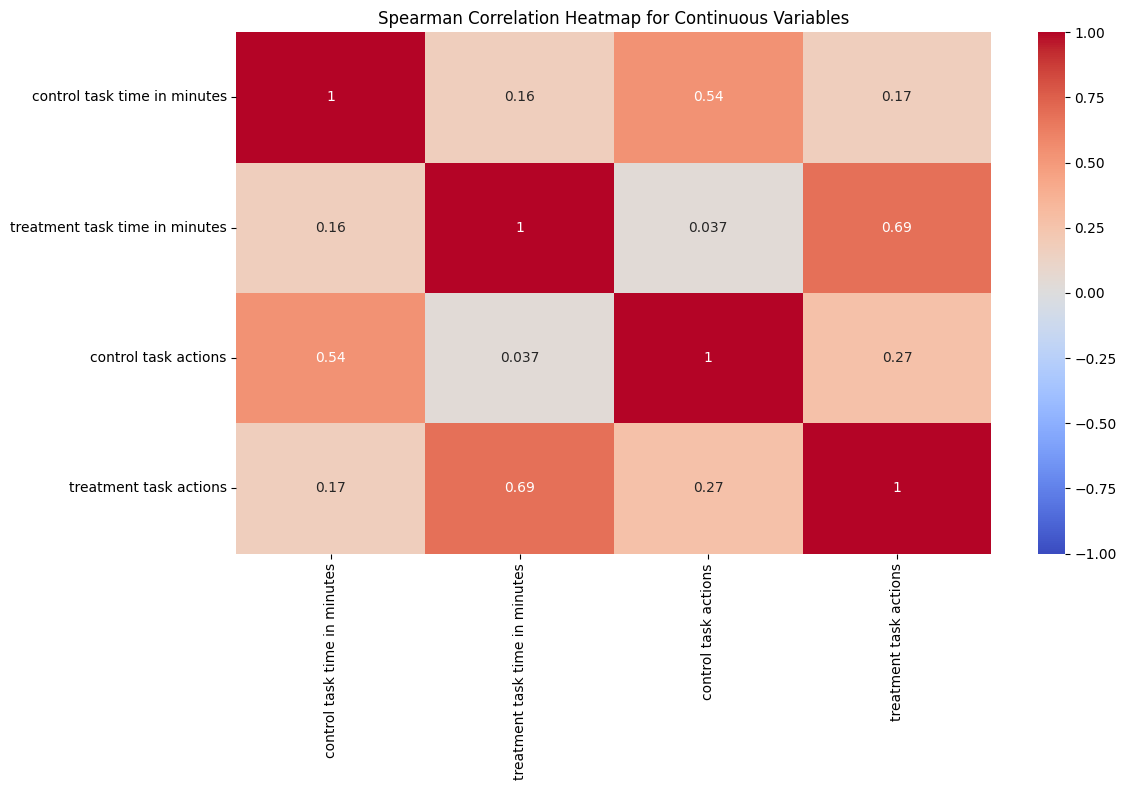

Spearman correlation heatmap saved as 'spearman_correlation_heatmap.png'


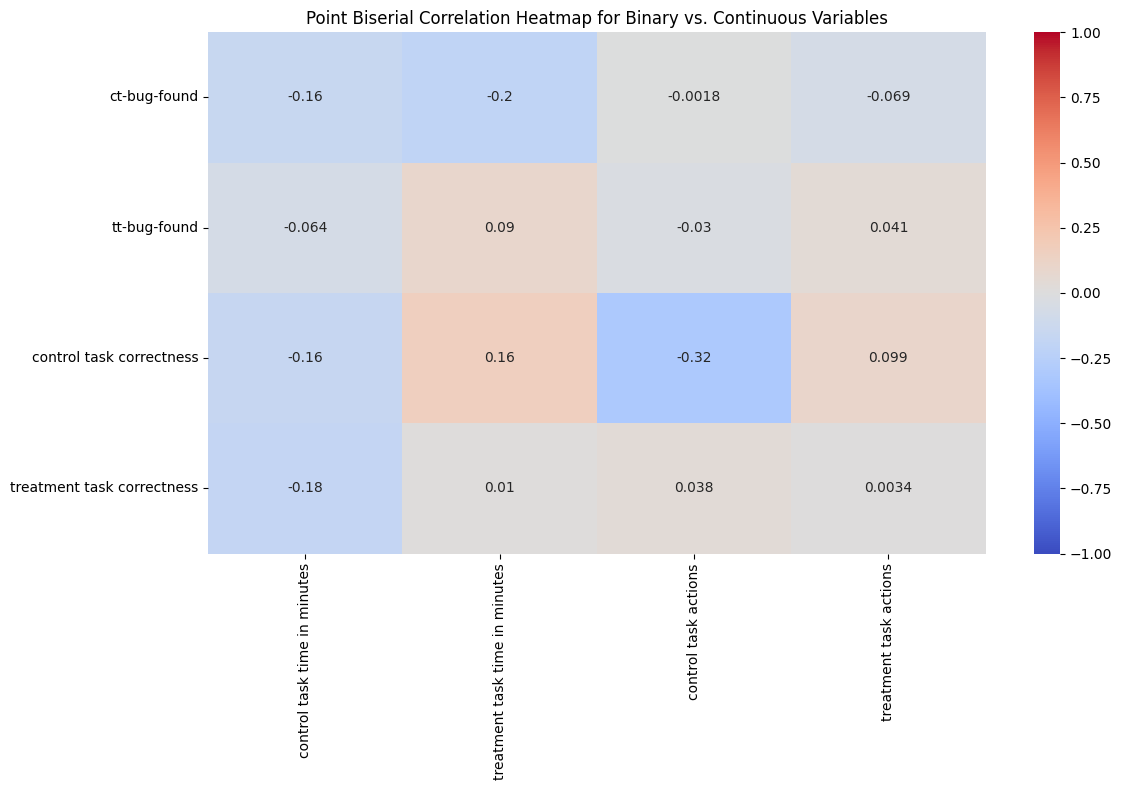

Point Biserial correlation heatmap saved as 'pointbiserial_correlation_heatmap.png'


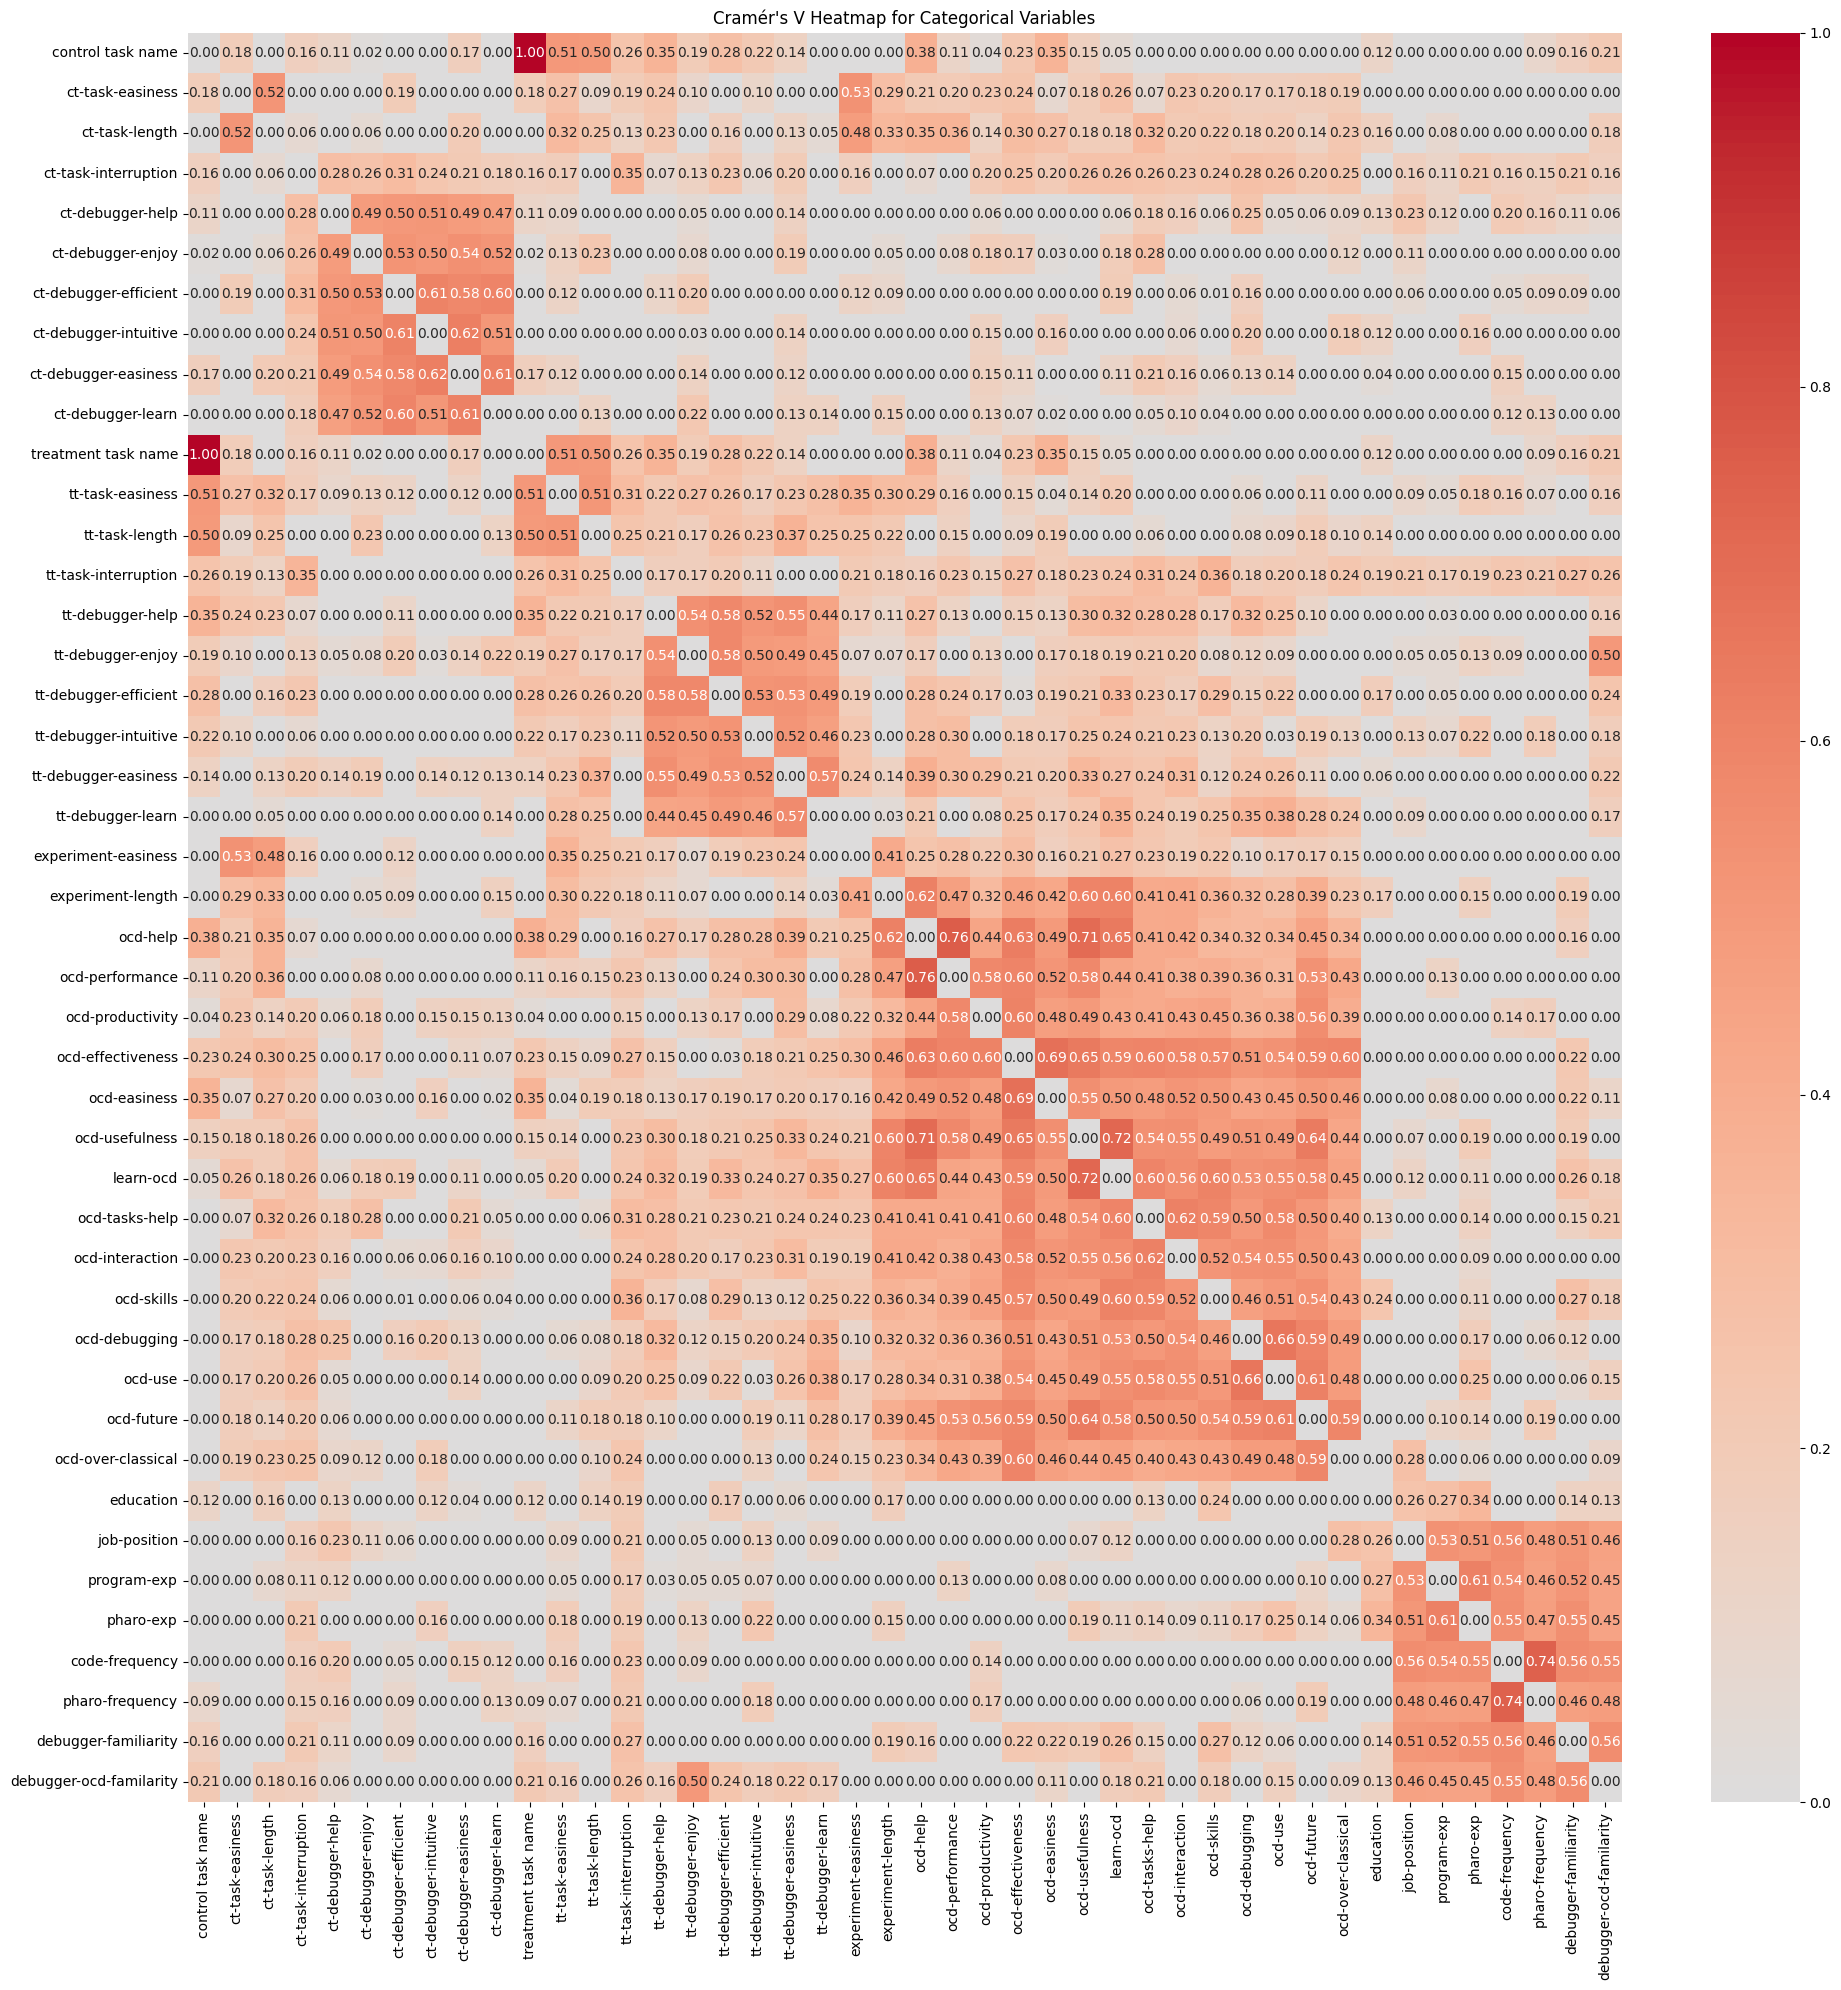

Cramér's V heatmap saved as 'cramers_v_heatmap.png'


In [522]:

# Function to compute Spearman correlation matrix for continuous variables
def compute_spearman_correlation(df, cols):
    corr_matrix = df[cols].corr(method='spearman')
    return corr_matrix

# Function to compute point biserial correlation for binary vs. continuous variables
def compute_pointbiserial_correlation(df, binary_vars, continuous_vars):
    correlations = {}
    for binary_var in binary_vars:
        for continuous_var in continuous_vars:
            combined = df[[binary_var, continuous_var]].dropna()
            if len(combined) > 1:
                corr, _ = pointbiserialr(combined[binary_var], combined[continuous_var])
                correlations[(binary_var, continuous_var)] = corr
    return correlations


# Function to compute Cramér's V for categorical variables
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))    
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Compute the correlation matrices
spearman_corr = compute_spearman_correlation(data, continuous_vars)
pointbiserial_corr = compute_pointbiserial_correlation(data, binary_vars, continuous_vars)
cramers_v_corr = {}


# Compute Cramér's V for each pair of categorical variables
for cat_var1 in categorical_vars:
    for cat_var2 in categorical_vars:
        if cat_var1 != cat_var2:
            cramers_v_corr[(cat_var1, cat_var2)] = cramers_v(data[cat_var1].astype(str), data[cat_var2].astype(str))

# Convert point biserial correlations to DataFrame
pointbiserial_corr_df = pd.DataFrame(index=binary_vars, columns=continuous_vars)
for (binary_var, continuous_var), corr in pointbiserial_corr.items():
    pointbiserial_corr_df.loc[binary_var, continuous_var] = corr

# Convert Cramér's V correlations to DataFrame
cramers_v_corr_df = pd.DataFrame(index=categorical_vars, columns=categorical_vars)
for (cat_var1, cat_var2), corr in cramers_v_corr.items():
    cramers_v_corr_df.loc[cat_var1, cat_var2] = corr

# Fill missing values with 0 in pointbiserial_corr_df and cramers_v_corr_df
pointbiserial_corr_df = pointbiserial_corr_df.fillna(0)
cramers_v_corr_df = cramers_v_corr_df.fillna(0)

# Plot the Spearman correlation heatmap for continuous variables
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Spearman Correlation Heatmap for Continuous Variables')
plt.tight_layout()
plt.show()
#plt.savefig('spearman_correlation_heatmap.png', dpi=300)
plt.close()

print("Spearman correlation heatmap saved as 'spearman_correlation_heatmap.png'")

# Plot the Point Biserial correlation heatmap for binary vs. continuous variables
plt.figure(figsize=(12, 8))
sns.heatmap(pointbiserial_corr_df.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Point Biserial Correlation Heatmap for Binary vs. Continuous Variables')
plt.tight_layout()
plt.show()
#plt.savefig('pointbiserial_correlation_heatmap.png', dpi=300)
plt.close()

print("Point Biserial correlation heatmap saved as 'pointbiserial_correlation_heatmap.png'")

# Plot the Cramér's V heatmap for categorical variables
plt.figure(figsize=(20, 20))
sns.heatmap(cramers_v_corr_df.astype(float), annot=True, fmt='.2f', cmap='coolwarm', vmin=0, vmax=1, center=0)
plt.title('Cramér\'s V Heatmap for Categorical Variables')
plt.tight_layout()
plt.show()
#plt.savefig('cramers_v_heatmap.png', dpi=300)
plt.close()

print("Cramér's V heatmap saved as 'cramers_v_heatmap.png'")

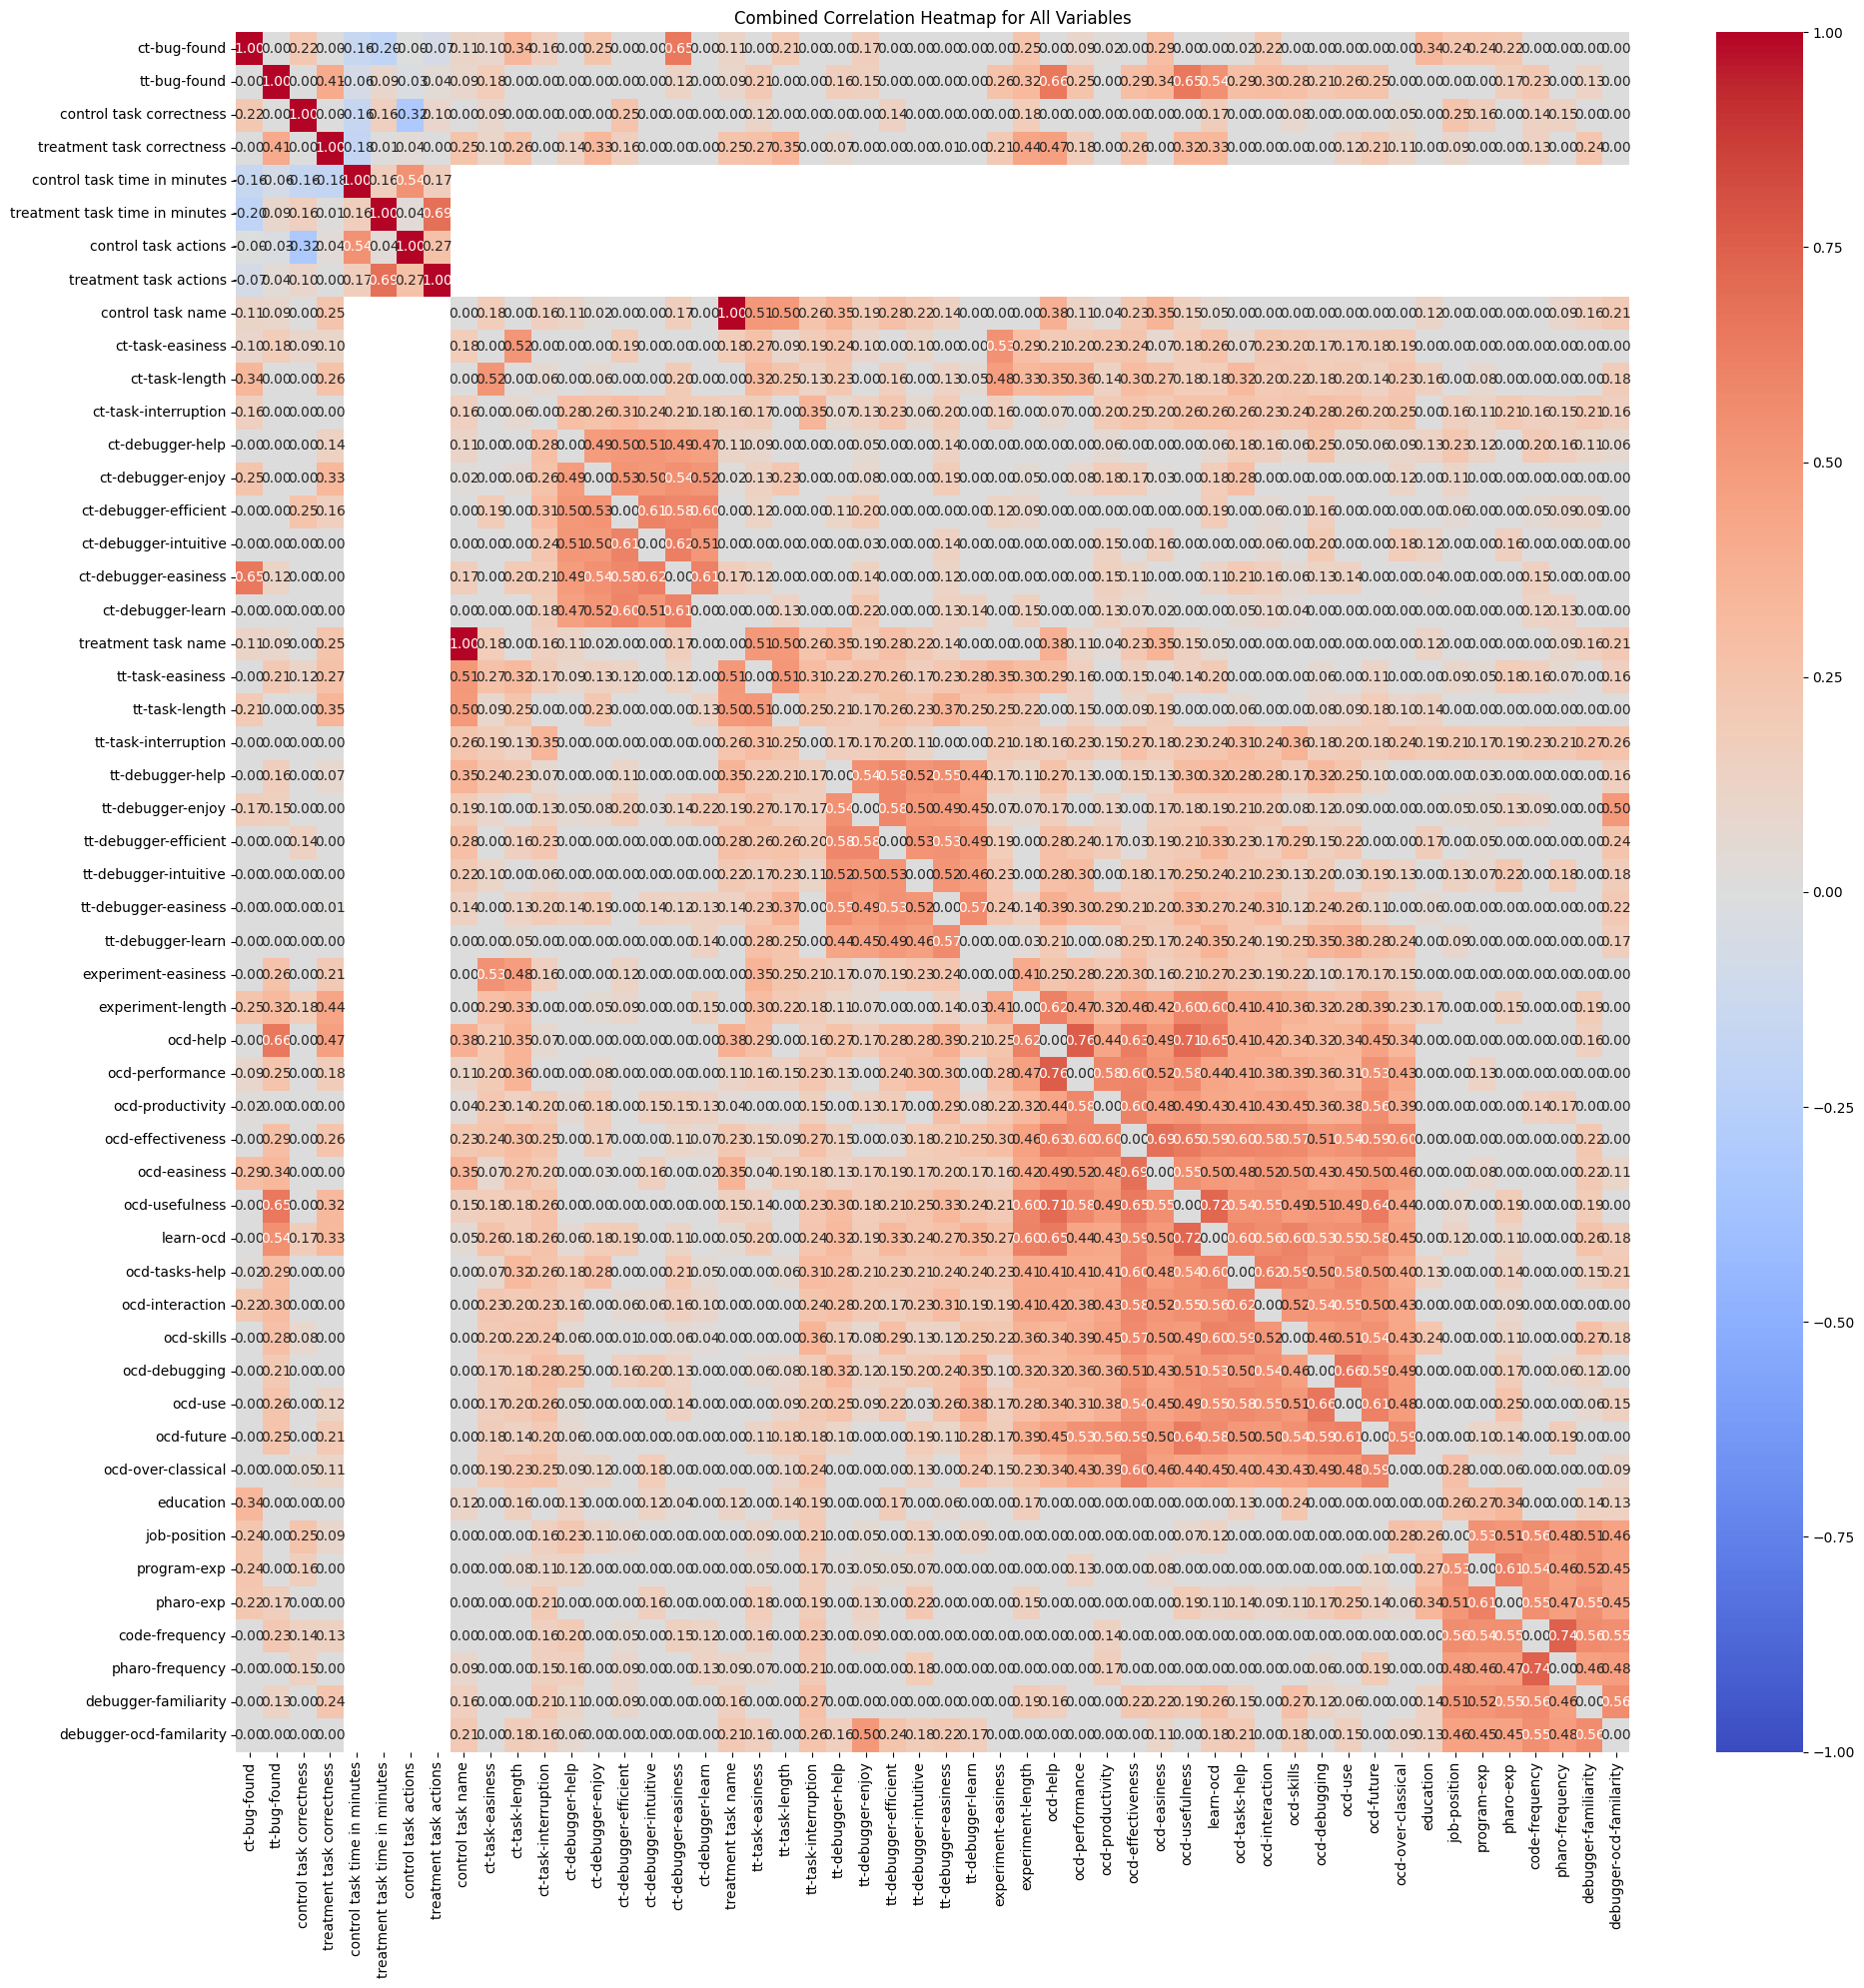

In [523]:
# Combine all correlations into one matrix
all_vars = binary_vars + continuous_vars + categorical_vars
combined_corr_df = pd.DataFrame(index=all_vars, columns=all_vars)

# Fill combined_corr_df with appropriate correlation values
for var1 in all_vars:
    for var2 in all_vars:
        if var1 in continuous_vars and var2 in continuous_vars:
            combined_corr_df.loc[var1, var2] = spearman_corr.loc[var1, var2]
        elif var1 in binary_vars and var2 in continuous_vars:
            if var1 in pointbiserial_corr_df.index and var2 in pointbiserial_corr_df.columns:
                combined_corr_df.loc[var1, var2] = pointbiserial_corr_df.loc[var1, var2]
        elif var1 in categorical_vars and var2 in categorical_vars:
            if var1 in cramers_v_corr_df.index and var2 in cramers_v_corr_df.columns:
                combined_corr_df.loc[var1, var2] = cramers_v_corr_df.loc[var1, var2]
        elif var1 in continuous_vars and var2 in binary_vars:
            if var2 in pointbiserial_corr_df.index and var1 in pointbiserial_corr_df.columns:
                combined_corr_df.loc[var1, var2] = pointbiserial_corr_df.loc[var2, var1]
        elif var1 in categorical_vars and var2 in continuous_vars:
            if var2 in pointbiserial_corr_df.index and var1 in pointbiserial_corr_df.columns:
                combined_corr_df.loc[var1, var2] = pointbiserial_corr_df.loc[var2, var1]
        elif var1 in binary_vars and var2 in categorical_vars:
            combined_corr_df.loc[var1, var2] = cramers_v(data[var1], data[var2])
        elif var1 in categorical_vars and var2 in binary_vars:
            combined_corr_df.loc[var1, var2] = cramers_v(data[var2], data[var1])
        elif var1 in binary_vars and var2 in binary_vars:
            combined_corr_df.loc[var1, var2] = cramers_v(data[var1], data[var2])



# Plot the combined correlation heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(combined_corr_df.astype(float), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Combined Correlation Heatmap for All Variables')
plt.tight_layout()
plt.show()
plt.close()

# Save the combined correlation matrix to a CSV file    
corr_output_csv_path = os.path.join(extraction_dir, 'corr_data.csv')
data.to_csv(corr_output_csv_path, index=False)

In [524]:
#print(combined_data.head())
print(data.head())

   control task name  control task correctness  control task time in minutes  \
2                  1                         1                     15.066667   
3                  0                         1                     17.666667   
5                  1                         1                     23.900000   
6                  1                         1                     46.533333   
7                  0                         1                     24.066667   

   control task actions  ct-task-easiness  ct-task-length  \
2                  56.0                 3               3   
3                  67.0                 4               4   
5                  12.0                 3               3   
6                 330.0                 3               3   
7                  13.0                 3               2   

   ct-task-interruption  ct-bug-found  ct-debugger-help  ct-debugger-enjoy  \
2                     2             1                 4                  4

In [525]:
clean_data = pd.read_csv(corr_output_csv_path)
print(clean_data.head())

   control task name  control task correctness  control task time in minutes  \
0                  1                         1                     15.066667   
1                  0                         1                     17.666667   
2                  1                         1                     23.900000   
3                  1                         1                     46.533333   
4                  0                         1                     24.066667   

   control task actions  ct-task-easiness  ct-task-length  \
0                  56.0               3.0             3.0   
1                  67.0               4.0             4.0   
2                  12.0               3.0             3.0   
3                 330.0               3.0             3.0   
4                  13.0               3.0             2.0   

   ct-task-interruption  ct-bug-found  ct-debugger-help  ct-debugger-enjoy  \
0                   2.0           1.0               4.0                4.0

In [526]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Log-transform the time variables to handle non-normality
clean_data['log_control_task_time'] = np.log1p(clean_data['control task time in minutes'])
clean_data['log_treatment_task_time'] = np.log1p(clean_data['treatment task time in minutes'])

# Select significant predictors based on the correlation matrices
predictors_time = ['ct-task-length','tt-task-length', 'ct-task-interruption','tt-task-interruption', 'debugger-ocd-familarity', 'education', 'pharo-exp', 'program-exp','control task name', 'treatment task name']
predictors_actions = ['control task correctness', 'treatment task correctness','debugger-ocd-familarity','education', 'pharo-exp', 'program-exp','control task name', 'treatment task name']

# Include task type as a confounding variable
clean_data['task_type'] = np.where(clean_data['control task name'] == 0, 'Ammolite', 'Lights Out')

# Remove rows with NaN values in any of the selected columns
original_length = len(clean_data)
clean_data = clean_data.dropna(subset=predictors_time + predictors_actions + 
                               ['control task time in minutes', 'treatment task time in minutes', 
                                'control task actions', 'treatment task actions'])
dropped_records = original_length - len(clean_data)
print(f"Number of records dropped due to NaN values: {dropped_records}")

# Split the data into training and testing sets
X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(
    clean_data[predictors_time], clean_data['control task time in minutes'], test_size=0.2, random_state=42)

X_train_actions, X_test_actions, y_train_actions, y_test_actions = train_test_split(
    clean_data[predictors_actions], clean_data['control task actions'], test_size=0.2, random_state=42)

# Fit Gamma GLM for control task time
gamma_model_control = smf.glm(formula='Q("control task time in minutes") ~ ' + ' + '.join([f'Q("{col}")' for col in predictors_time]),
                              data=clean_data, family=sm.families.Gamma(link=sm.families.links.Log())).fit()

# Fit Gamma GLM for treatment task time
gamma_model_treatment = smf.glm(formula='Q("treatment task time in minutes") ~ ' + ' + '.join([f'Q("{col}")' for col in predictors_time]),
                                data=clean_data, family=sm.families.Gamma(link=sm.families.links.Log())).fit()

# Predict and evaluate for control task time
y_pred_time_control = gamma_model_control.predict(X_test_time)
print("Gamma GLM for Control Task Time:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_time, y_pred_time_control)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_time, y_pred_time_control)}")

# Predict and evaluate for treatment task time
y_pred_time_treatment = gamma_model_treatment.predict(X_test_time)
print("Gamma GLM for Treatment Task Time:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_time, y_pred_time_treatment)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_time, y_pred_time_treatment)}")


# Fit Negative Binomial GLM for control task actions
nb_model_control = smf.glm(formula='Q("control task actions") ~ ' + ' + '.join([f'Q("{col}")' for col in predictors_actions]),
                           data=clean_data, family=sm.families.NegativeBinomial(),alpha=1.0).fit()

# Fit Negative Binomial GLM for treatment task actions
nb_model_treatment = smf.glm(formula='Q("treatment task actions") ~ ' + ' + '.join([f'Q("{col}")' for col in predictors_actions]),
                             data=clean_data, family=sm.families.NegativeBinomial(), alpha=1.0).fit()

# Predict and evaluate for control task actions
y_pred_actions_control = nb_model_control.predict(X_test_actions)
print("\nNegative Binomial GLM for Control Task Actions:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_actions, y_pred_actions_control)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_actions, y_pred_actions_control)}")

# Predict and evaluate for treatment task actions
y_pred_actions_treatment = nb_model_treatment.predict(X_test_actions)
print("\nNegative Binomial GLM for Treatment Task Actions:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_actions, y_pred_actions_treatment)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_actions, y_pred_actions_treatment)}")

# Interpret the results
print("\nModel Summary for Control Task Time (Gamma GLM):")
print(gamma_model_control.summary())

print("\nModel Summary for Treatment Task Time (Gamma GLM):")
print(gamma_model_treatment.summary())

print("\nModel Summary for Control Task Actions (Negative Binomial GLM):")
print(nb_model_control.summary())

print("\nModel Summary for Treatment Task Actions (Negative Binomial GLM):")
print(nb_model_treatment.summary())

Number of records dropped due to NaN values: 9
Gamma GLM for Control Task Time:
Mean Absolute Error: 5.268776325682852
Mean Squared Error: 36.21020163180713
Gamma GLM for Treatment Task Time:
Mean Absolute Error: 13.914908573773099
Mean Squared Error: 311.25145118827993

Negative Binomial GLM for Control Task Actions:
Mean Absolute Error: 45.14170339885952
Mean Squared Error: 2413.249976989554

Negative Binomial GLM for Treatment Task Actions:
Mean Absolute Error: 58.95904642279258
Mean Squared Error: 4871.128549266532

Model Summary for Control Task Time (Gamma GLM):
                         Generalized Linear Model Regression Results                         
Dep. Variable:     Q("control task time in minutes")   No. Observations:                   50
Model:                                           GLM   Df Residuals:                       40
Model Family:                                  Gamma   Df Model:                            9
Link Function:                                   

/Users/poojarani/anaconda3/envs/OCD-survey-analysis/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/poojarani/anaconda3/envs/OCD-survey-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['alpha']
  warnings.warn(msg, ValueWarning)
/Users/poojarani/anaconda3/envs/OCD-survey-analysis/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/poojarani/anaconda3/envs/OCD-survey-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['alpha']
  warnings.warn(msg, ValueWarning)


In [530]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to compute standardized coefficients for effect sizes
def compute_standardized_coefficients(model, data):
    params = model.params
    standardized_params = params.copy()
    for variable in params.index:
        if variable == 'Intercept':
            continue
        standardized_params[variable] = params[variable] * (data[variable].std() / data[model.model.endog_names].std())
    return standardized_params


# Log-transform the time variables to handle non-normality
clean_data['log_treatment_task_time'] = np.log1p(clean_data['treatment task time in minutes'])

# Filter data for treatment group only (columns not starting with 'control' or 'ct-')
treatment_columns = [col for col in clean_data.columns if not col.startswith('control') and not col.startswith('ct-')]
treatment_data = clean_data[treatment_columns]

# Select significant predictors based on the previous analysis
predictors_time = ['tt_task_easiness', 'tt_task_length', 'tt_task_interruption', 'tt_bug_found',
                   'experiment-length','treatment_task_actions', 'ocd_interaction', 'education','pharo_exp']
predictors_actions = ['tt_task_easiness', 'tt_task_length', 'tt_task_interruption', 'tt_bug_found',
                      'treatment_task_time_in_minutes', 'ocd_interaction', 'education', 'pharo_exp']


# Rename columns to remove special characters
treatment_data.columns = treatment_data.columns.str.replace(' ', '_').str.replace('-', '_')

# Update predictors list after renaming columns
predictors_time = [col.replace(' ', '_').replace('-', '_') for col in predictors_time]
predictors_actions = [col.replace(' ', '_').replace('-', '_') for col in predictors_actions]

# Remove rows with NaN values in any of the selected columns
treatment_data = treatment_data.dropna(subset=predictors_time + predictors_actions +
                                       ['treatment_task_time_in_minutes', 'treatment_task_actions'])

# Split the data into training and testing sets for time
X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(
    treatment_data[predictors_time], treatment_data['treatment_task_time_in_minutes'], test_size=0.2, random_state=42)

# Split the data into training and testing sets for actions
X_train_actions, X_test_actions, y_train_actions, y_test_actions = train_test_split(
    treatment_data[predictors_actions], treatment_data['treatment_task_actions'], test_size=0.2, random_state=42)

# Prepare training and testing data for formula-based model fitting
train_time_data = X_train_time.copy()
train_time_data['treatment_task_time_in_minutes'] = y_train_time

test_time_data = X_test_time.copy()
test_time_data['treatment_task_time_in_minutes'] = y_test_time

train_actions_data = X_train_actions.copy()
train_actions_data['treatment_task_actions'] = y_train_actions

test_actions_data = X_test_actions.copy()
test_actions_data['treatment_task_actions'] = y_test_actions

# Fit Gamma GLM for treatment task time
gamma_model_treatment = smf.glm(formula='treatment_task_time_in_minutes ~ ' + ' + '.join(predictors_time),
                                data=train_time_data, family=sm.families.Gamma(link=sm.families.links.log())).fit()

# Predict and evaluate for treatment task time
y_pred_time_treatment = gamma_model_treatment.predict(test_time_data)
print("Gamma GLM for Treatment Task Time:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_time, y_pred_time_treatment)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_time, y_pred_time_treatment)}")

# Compute and print standardized coefficients for the Gamma GLM
standardized_coefficients_time = compute_standardized_coefficients(gamma_model_treatment, treatment_data)
print("\nStandardized Coefficients for Treatment Task Time (Gamma GLM):")
print(standardized_coefficients_time)

# Fit Negative Binomial GLM for treatment task actions
nb_model_treatment = smf.glm(formula='treatment_task_actions ~ ' + ' + '.join(predictors_actions),
                             data=train_actions_data, family=sm.families.NegativeBinomial()).fit()

# Predict and evaluate for treatment task actions
y_pred_actions_treatment = nb_model_treatment.predict(test_actions_data)
print("\nNegative Binomial GLM for Treatment Task Actions:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_actions, y_pred_actions_treatment)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_actions, y_pred_actions_treatment)}")

# Compute and print exponentiated coefficients (effect sizes) for the Negative Binomial GLM
effect_sizes_actions = np.exp(nb_model_treatment.params)
print("\nEffect Sizes for Treatment Task Actions (Negative Binomial GLM):")
print(effect_sizes_actions)

# Interpret the results
print("\nModel Summary for Treatment Task Time (Gamma GLM):")
print(gamma_model_treatment.summary())

print("\nModel Summary for Treatment Task Actions (Negative Binomial GLM):")
print(nb_model_treatment.summary())

Gamma GLM for Treatment Task Time:
Mean Absolute Error: 11.241668028007636
Mean Squared Error: 192.91113774450835

Standardized Coefficients for Treatment Task Time (Gamma GLM):
Intercept                 4.130948
tt_task_easiness         -0.020160
tt_task_length            0.002673
tt_task_interruption      0.005079
tt_bug_found              0.001626
experiment_length         0.000013
treatment_task_actions    0.011008
ocd_interaction          -0.000910
education                -0.002246
pharo_exp                -0.008993
dtype: float64

Negative Binomial GLM for Treatment Task Actions:
Mean Absolute Error: 154.97513816668842
Mean Squared Error: 92655.43039414778

Effect Sizes for Treatment Task Actions (Negative Binomial GLM):
Intercept                         71.257790
tt_task_easiness                   0.795142
tt_task_length                     0.781091
tt_task_interruption               1.073956
tt_bug_found                       2.102969
treatment_task_time_in_minutes     1.05366

/Users/poojarani/anaconda3/envs/OCD-survey-analysis/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/poojarani/anaconda3/envs/OCD-survey-analysis/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [531]:
# Filter data for control group only (columns not starting with 'control' or 'ct-')
control_columns = [col for col in clean_data.columns if not col.startswith('treatment') and not col.startswith('tt-')]
ct_data = clean_data[control_columns]
print(ct_data['control task name'].value_counts(dropna=False))
ct_data.columns = ct_data.columns.str.replace(' ', '_').str.replace('-', '_')
print(ct_data.columns)

control task name
1    25
0    25
Name: count, dtype: int64
Index(['control_task_name', 'control_task_correctness',
       'control_task_time_in_minutes', 'control_task_actions',
       'ct_task_easiness', 'ct_task_length', 'ct_task_interruption',
       'ct_bug_found', 'ct_debugger_help', 'ct_debugger_enjoy',
       'ct_debugger_efficient', 'ct_debugger_intuitive',
       'ct_debugger_easiness', 'ct_debugger_learn', 'experiment_easiness',
       'experiment_length', 'ocd_help', 'ocd_performance', 'ocd_productivity',
       'ocd_effectiveness', 'ocd_easiness', 'ocd_usefulness', 'learn_ocd',
       'ocd_tasks_help', 'ocd_interaction', 'ocd_skills', 'ocd_debugging',
       'ocd_use', 'ocd_future', 'ocd_over_classical', 'education',
       'job_position', 'program_exp', 'pharo_exp', 'code_frequency',
       'pharo_frequency', 'debugger_familiarity', 'debugger_ocd_familarity',
       'log_control_task_time', 'log_treatment_task_time', 'task_type'],
      dtype='object')


In [532]:
tt_data = treatment_data.copy()

In [533]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display the first few rows of the initial data to verify the column
#print("Initial data (first few rows):")
#print(tt_data.head())
#print(ct_data.head())

# Display the unique values and counts in the 'treatment_task_name' column
print("Unique values in 'treatment_task_name' and 'control_task_name' column:")
print(tt_data['treatment_task_name'].value_counts(dropna=False))
print(ct_data['control_task_name'].value_counts(dropna=False))

Unique values in 'treatment_task_name' and 'control_task_name' column:
treatment_task_name
0    25
1    24
Name: count, dtype: int64
control_task_name
1    25
0    25
Name: count, dtype: int64


In [534]:
# Map 0 and 1 to actual task names if necessary
task_mapping = {0: 'Ammolite', 1: 'Lights Out'}
tt_data['treatment_task_name'] = tt_data['treatment_task_name'].map(task_mapping)
ct_data['control_task_name'] = ct_data['control_task_name'].map(task_mapping)

# Ensure there are no NaN values in the columns of interest
treatment_data_clean = tt_data.dropna(subset=['tt_task_easiness', 'treatment_task_name'])
control_data_clean = ct_data.dropna(subset=['ct_task_easiness', 'control_task_name'])

# Distribution of task names after cleaning
print("Task distribution after cleaning:")
print(treatment_data_clean['treatment_task_name'].value_counts())
print(control_data_clean['control_task_name'].value_counts())

# Group by task name and calculate the mean easiness score
task_easiness_means = treatment_data_clean.groupby('treatment_task_name')['tt_task_easiness'].mean().reset_index()
ct_task_easiness_means = control_data_clean.groupby('control_task_name')['ct_task_easiness'].mean().reset_index()

Task distribution after cleaning:
treatment_task_name
Ammolite      25
Lights Out    24
Name: count, dtype: int64
control_task_name
Lights Out    25
Ammolite      25
Name: count, dtype: int64


/var/folders/sl/9nkjwp050j37649nk4d77v480000gn/T/ipykernel_8152/2797038816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct_data['control_task_name'] = ct_data['control_task_name'].map(task_mapping)


/var/folders/sl/9nkjwp050j37649nk4d77v480000gn/T/ipykernel_8152/90698769.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=task_easiness_means, x='treatment_task_name', y='tt_task_easiness', palette='viridis')


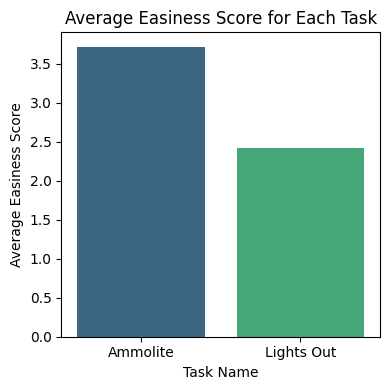

In [535]:
# Plot the results
plt.figure(figsize=(4, 4))
sns.barplot(data=task_easiness_means, x='treatment_task_name', y='tt_task_easiness', palette='viridis')
plt.title('Average Easiness Score for Each Task')
plt.xlabel('Task Name')
plt.ylabel('Average Easiness Score')
plt.tight_layout()
plt.show()

/var/folders/sl/9nkjwp050j37649nk4d77v480000gn/T/ipykernel_8152/1676725490.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ct_task_easiness_means, x='control_task_name', y='ct_task_easiness', palette='viridis')


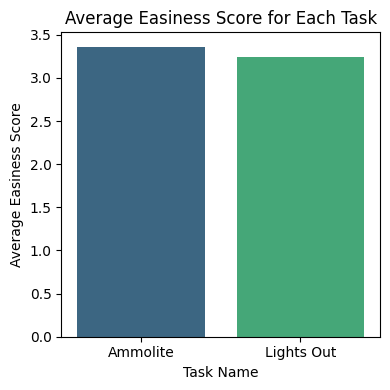

In [536]:
# Plot the results
plt.figure(figsize=(4, 4))
sns.barplot(data=ct_task_easiness_means, x='control_task_name', y='ct_task_easiness', palette='viridis')
plt.title('Average Easiness Score for Each Task')
plt.xlabel('Task Name')
plt.ylabel('Average Easiness Score')
plt.tight_layout()
plt.show()

Mann-Whitney U test for Task easiness between Tasks for the Groups (control of treatment)

In [537]:
from scipy.stats import mannwhitneyu

# Separate the easiness scores by task
ammolite_easiness = treatment_data_clean[treatment_data_clean['treatment_task_name'] == 'Ammolite']['tt_task_easiness']
lightsout_easiness = treatment_data_clean[treatment_data_clean['treatment_task_name'] == 'Lights Out']['tt_task_easiness']
ct_ammolite_easiness = control_data_clean[control_data_clean['control_task_name'] == 'Ammolite']['ct_task_easiness']
ct_lightsout_easiness = control_data_clean[control_data_clean['control_task_name'] == 'Lights Out']['ct_task_easiness']

# Ensure the series are not empty before performing the test
if not ammolite_easiness.empty and not lightsout_easiness.empty:
    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(ammolite_easiness, lightsout_easiness)
    print(f"Mann-Whitney U Test: Statistic for Treatment={stat}, p-value={p_value}")

    # Calculate rank-biserial correlation
    n1, n2 = len(ammolite_easiness), len(lightsout_easiness)
    rank_biserial_corr = (stat - (n1 * n2) / 2) / (n1 * n2)
    print(f"Rank-Biserial Correlation: {rank_biserial_corr}")
else:
    print("One of the task groups has no data after cleaning.")

# Ensure the series are not empty before performing the test
if not ct_ammolite_easiness.empty and not ct_lightsout_easiness.empty:
    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(ct_ammolite_easiness, ct_lightsout_easiness)
    print(f"Mann-Whitney U Test: Statistic for Control={stat}, p-value={p_value}")

    # Calculate rank-biserial correlation
    n1, n2 = len(ct_ammolite_easiness), len(ct_lightsout_easiness)
    rank_biserial_corr = (stat - (n1 * n2) / 2) / (n1 * n2)
    print(f"Rank-Biserial Correlation: {rank_biserial_corr}")
else:
    print("One of the task groups has no data after cleaning.")


Mann-Whitney U Test: Statistic for Treatment=488.0, p-value=0.0001116629584975945
Rank-Biserial Correlation: 0.31333333333333335
Mann-Whitney U Test: Statistic for Control=342.5, p-value=0.5469356361856368
Rank-Biserial Correlation: 0.048


Plot the distributions of easiness scores for Treatment group

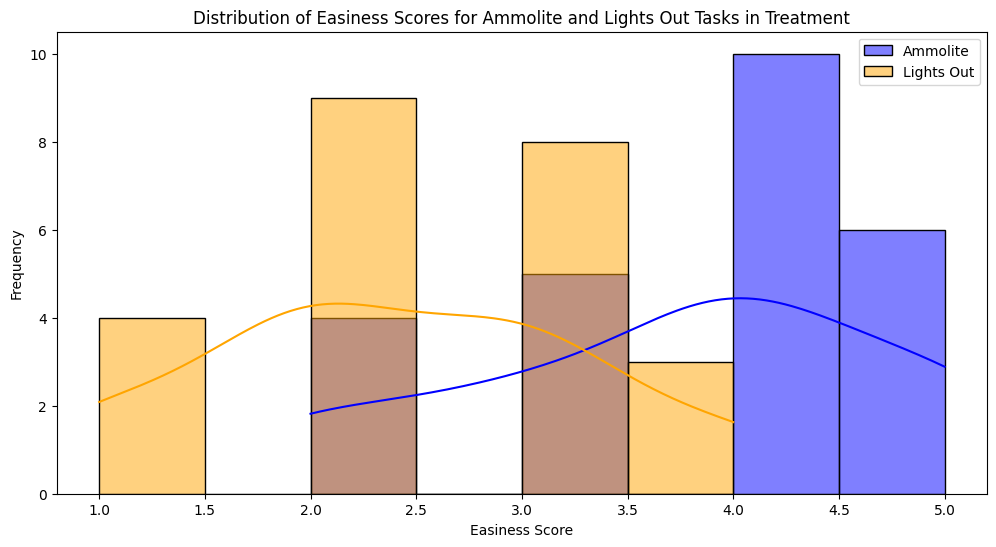

In [538]:
# Plot the distributions of easiness scores
plt.figure(figsize=(12, 6))
sns.histplot(ammolite_easiness, kde=True, label='Ammolite', color='blue')
sns.histplot(lightsout_easiness, kde=True, label='Lights Out', color='orange')
plt.title('Distribution of Easiness Scores for Ammolite and Lights Out Tasks in Treatment')
plt.xlabel('Easiness Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Plot the distributions of easiness scores for Control group

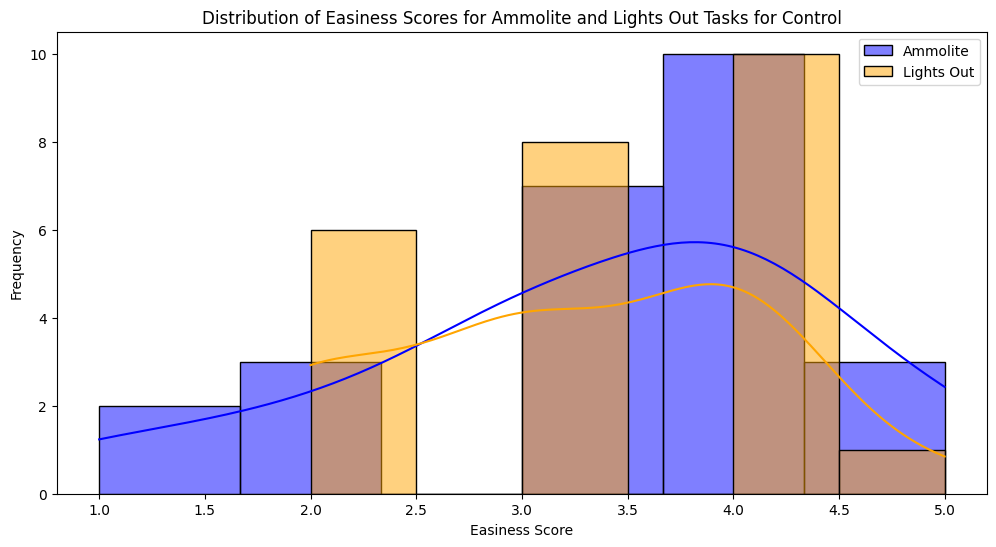

In [539]:

plt.figure(figsize=(12, 6))
sns.histplot(ct_ammolite_easiness, kde=True, label='Ammolite', color='blue')
sns.histplot(ct_lightsout_easiness, kde=True, label='Lights Out', color='orange')
plt.title('Distribution of Easiness Scores for Ammolite and Lights Out Tasks for Control')
plt.xlabel('Easiness Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Check the Assumption of Regression models

The dependent variable 'treatment_task_actions' is count data (non-negative integers).
Mean of 'treatment_task_actions': 77.75510204081633
Variance of 'treatment_task_actions': 14622.980442176871
There is overdispersion in the data.


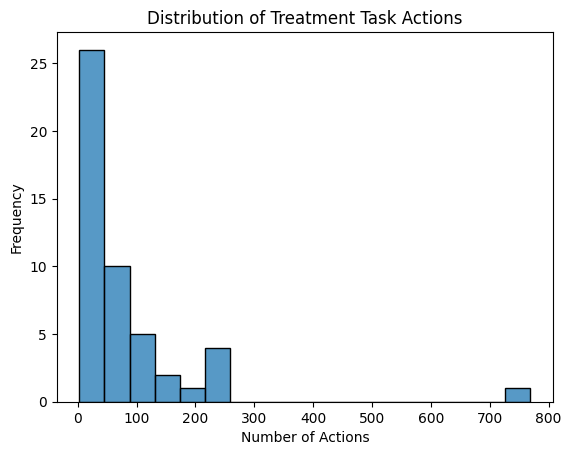

Number of zeros: 0
Total count: 49
Percentage of zeros: 0.00%


In [545]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned treatment data
# Assuming treatment_data is already cleaned and available from the previous steps

# Check if the dependent variable is count data
if not np.issubdtype(treatment_data['treatment_task_actions'].dtype, np.integer):
    print("The dependent variable 'treatment_task_actions' is not count data (non-negative integers).")
else:
    print("The dependent variable 'treatment_task_actions' is count data (non-negative integers).")

# Check for overdispersion
mean_actions = treatment_data['treatment_task_actions'].mean()
variance_actions = treatment_data['treatment_task_actions'].var()

print(f"Mean of 'treatment_task_actions': {mean_actions}")
print(f"Variance of 'treatment_task_actions': {variance_actions}")

if variance_actions > mean_actions:
    print("There is overdispersion in the data.")
else:
    print("There is no overdispersion in the data.")
    
# Visualize the distribution of the dependent variable
sns.histplot(treatment_data['treatment_task_actions'], kde=False)
plt.title('Distribution of Treatment Task Actions')
plt.xlabel('Number of Actions')
plt.ylabel('Frequency')
plt.show()

# Check the number of zeros in the treatment_task_actions to check zero-inflation
num_zeros = (treatment_data['treatment_task_actions'] == 0).sum()
total_count = len(treatment_data['treatment_task_actions'])

print(f"Number of zeros: {num_zeros}")
print(f"Total count: {total_count}")
print(f"Percentage of zeros: {num_zeros / total_count * 100:.2f}%")


In [546]:
#clean_data = pd.read_csv(output_csv_path)
print(clean_data.head())

   control task name  control task correctness  control task time in minutes  \
0                  1                         1                     15.066667   
1                  0                         1                     17.666667   
2                  1                         1                     23.900000   
3                  1                         1                     46.533333   
4                  0                         1                     24.066667   

   control task actions  ct-task-easiness  ct-task-length  \
0                  56.0               3.0             3.0   
1                  67.0               4.0             4.0   
2                  12.0               3.0             3.0   
3                 330.0               3.0             3.0   
4                  13.0               3.0             2.0   

   ct-task-interruption  ct-bug-found  ct-debugger-help  ct-debugger-enjoy  \
0                   2.0           1.0               4.0                4.0

Fit Quasi-Poisson GLM for treatment task actions

In [547]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Log-transform the time variables to handle non-normality
# clean_data['log_treatment_task_time'] = np.log1p(clean_data['treatment_task_time_in_minutes'])

# Filter data for treatment group only (columns not starting with 'control' or 'ct-')
#treatment_columns = [col for col in clean_data.columns if not col.startswith('control') and not col.startswith('ct-')]
#treatment_data = clean_data[treatment_columns]

# Select significant predictors based on the previous analysis
predictors_actions = ['tt_task_easiness', 'tt_task_length', 'tt_task_interruption', 'tt_bug_found',
                      'treatment_task_time_in_minutes', 'ocd_interaction', 'education', 'pharo_exp']

# Remove rows with NaN values in any of the selected columns
# treatment_data = treatment_data.dropna(subset=predictors_actions + ['treatment_task_actions'])

# Ensure treatment_task_actions is rounded to integer for count models
treatment_data['treatment_task_actions'] = treatment_data['treatment_task_actions'].round().astype(int)

# Split the data into training and testing sets for actions
X_train_actions, X_test_actions, y_train_actions, y_test_actions = train_test_split(
    treatment_data[predictors_actions], treatment_data['treatment_task_actions'], test_size=0.2, random_state=42)

# Prepare training and testing data for formula-based model fitting
train_actions_data = X_train_actions.copy()
train_actions_data['treatment_task_actions'] = y_train_actions

test_actions_data = X_test_actions.copy()
test_actions_data['treatment_task_actions'] = y_test_actions

# Fit Quasi-Poisson GLM for treatment task actions
qp_model_treatment = smf.glm(formula='treatment_task_actions ~ ' + ' + '.join(predictors_actions),
                                data=train_actions_data,  family=sm.families.Poisson()).fit(scale='x2')

# Predict and evaluate for treatment task actions
y_pred_actions_treatment = qp_model_treatment.predict(test_actions_data)
print("\nQuasi-Poisson GLM for Treatment Task Actions:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_actions, y_pred_actions_treatment)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_actions, y_pred_actions_treatment)}")

# Interpret the results
print("\nModel Summary for Treatment Task Actions (Quasi-Poisson GLM):")
print(qp_model_treatment.summary())

# Compute and print standardized coefficients for the Quasi-Poisson GLM
def compute_standardized_coefficients(model, data):
    params = model.params
    standardized_params = {}
    for variable in params.index:
        if variable == 'Intercept':
            continue
        standardized_params[variable] = params[variable] * (data[variable].std() / data[model.model.endog_names].std())
    return pd.Series(standardized_params)

standardized_coefficients_actions = compute_standardized_coefficients(qp_model_treatment, treatment_data)
print("\nStandardized Coefficients for Treatment Task Actions (Quasi-Poisson GLM):")
print(standardized_coefficients_actions)


Quasi-Poisson GLM for Treatment Task Actions:
Mean Absolute Error: 147.1817842720385
Mean Squared Error: 70537.47081714714

Model Summary for Treatment Task Actions (Quasi-Poisson GLM):
                   Generalized Linear Model Regression Results                    
Dep. Variable:     treatment_task_actions   No. Observations:                   39
Model:                                GLM   Df Residuals:                       30
Model Family:                     Poisson   Df Model:                            8
Link Function:                        Log   Scale:                          44.345
Method:                              IRLS   Log-Likelihood:                -15.073
Date:                    Thu, 11 Jul 2024   Deviance:                       1122.0
Time:                            10:45:33   Pearson chi2:                 1.33e+03
No. Iterations:                         7   Pseudo R-squ. (CS):             0.8505
Covariance Type:                nonrobust                         